check homphily per genre. some actor prefer to work with other actor in the same genre.
some genre are most influential than ohter in term of how connected the nodes are (degree)

build a graph per year, compute its distance, betweenes, etc per genre.


In [ ]:
#!pip install python-igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time
import numpy as np
import math
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [11,11]
#import igraph as ig

<ipython-input-44-fe9c78805c8a>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/aphdinh/socialnetwork/main/netflix_titles.csv')

# Drop rows with null directors
df = df.dropna(subset=['director'])

# Convert to datetime
df["date_added"] = pd.to_datetime(df['date_added'], infer_datetime_format=True, errors='coerce')
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day

# Convert columns to lists
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

# Create a new column 'num_directors' that counts the number of directors in each row
df['num_directors'] = df['directors'].apply(len)
df['num_categories'] = df['categories'].apply(len)
# Extract the first genre from the list and create a new column 'primary_genre'
df['primary_categories'] = df['categories'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

df.head()

<ipython-input-45-ed3ba9d5f883>:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["date_added"] = pd.to_datetime(df['date_added'], infer_datetime_format=True, errors='coerce')


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,year,month,day,directors,countries,categories,actors,num_directors,num_categories,primary_categories
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,...,2021.0,9.0,25.0,[Kirsten Johnson],[United States],[Documentaries],[],1,1,Documentaries
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,...,2021.0,9.0,24.0,[Julien Leclercq],[],"[Crime TV Shows, International TV Shows, TV Ac...","[Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nab...",1,3,Crime TV Shows
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",NaN,2021-09-24,2021,TV-MA,1 Season,...,2021.0,9.0,24.0,[Mike Flanagan],[],"[TV Dramas, TV Horror, TV Mysteries]","[Kate Siegel, Zach Gilford, Hamish Linklater, ...",1,3,TV Dramas
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,2021-09-24,2021,PG,91 min,...,2021.0,9.0,24.0,"[Robert Cullen, José Luis Ucha]",[],[Children & Family Movies],"[Vanessa Hudgens, Kimiko Glenn, James Marsden,...",2,1,Children & Family Movies
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...",2021-09-24,1993,TV-MA,125 min,...,2021.0,9.0,24.0,[Haile Gerima],"[United States, Ghana, Burkina Faso, United Ki...","[Dramas, Independent Movies, International Mov...","[Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra ...",1,3,Dramas


## to count movies per categories

In [ ]:
# Filter films produced in the USA
usa = df[df['countries'].apply(lambda x: 'United States' in x)]
usa = usa[usa.type == "Movie"]
usa.shape

(2684, 22)

## total movies per category

In [ ]:
usa_exploded = usa.explode('categories')
category_counts = usa_exploded['categories'].value_counts()
print(category_counts)
# Get the list of unique categories
categories = category_counts.index.tolist()


categories
Dramas                      830
Comedies                    667
Documentaries               483
Action & Adventure          401
Independent Movies          389
Children & Family Movies    376
Thrillers                   292
Romantic Movies             224
Stand-Up Comedy             209
Horror Movies               201
Sci-Fi & Fantasy            178
International Movies        160
Music & Musicals            142
Sports Movies               111
Classic Movies               81
LGBTQ Movies                 59
Cult Movies                  52
Faith & Spirituality         42
Movies                       14
Anime Features                7
Name: count, dtype: int64


In [ ]:
df.shape
print(df.columns)

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'year', 'month', 'day', 'directors', 'countries', 'categories',
       'actors', 'num_directors', 'num_categories', 'primary_categories'],
      dtype='object')


# more than 2 directors in movies

In [ ]:
usa[usa.num_directors>=2].head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,year,month,day,directors,countries,categories,actors,num_directors,num_categories,primary_categories
101,s102,Movie,Untold: Breaking Point,"Chapman Way, Maclain Way",NaN,United States,2021-09-07,2021,TV-MA,80 min,...,2021.0,9.0,7.0,"[Chapman Way, Maclain Way]",[United States],"[Documentaries, Sports Movies]",[],2,2,Documentaries
145,s146,Movie,House Party 2,"George Jackson, Doug McHenry","Christopher Reid, Christopher Martin, Martin L...",United States,2021-09-01,1991,R,94 min,...,2021.0,9.0,1.0,"[George Jackson, Doug McHenry]",[United States],"[Comedies, Cult Movies, Music & Musicals]","[Christopher Reid, Christopher Martin, Martin ...",2,3,Comedies


## graph actors and directors overtime

## functions

connections between other directors and actors is added when a movie has more than 2 directors

In [ ]:
import networkx as nx

def create_graph_from_df(df):
    # Initialize graph
    G = nx.Graph()

    for _, row in df.iterrows():
        directors = row['directors']
        actors = row['actors']
        categories = row['categories']

        for director in directors:
          G.add_node(director + '_d', type='director', category=categories)

        for actor in actors:
          G.add_node(actor + '_a', type='actor', category=categories)
          G.add_edge(director + '_d', actor + '_a')

        # Add edges between actors in the same project
        for i in range(len(actors)):
            for j in range(i + 1, len(actors)):
                G.add_edge(actors[i] + '_a', actors[j] + '_a')

        # Add edges between directors in the same project
        for i in range(len(directors)):
            for j in range(i + 1, len(directors)):
                G.add_edge(directors[i] + '_d', directors[j] + '_d')

     # Add edges between directors and actors only if there are more than 2 actors and directors
        if len(actors) > 2 and len(directors) > 2:
          for director in directors:
            for actor in actors:
              G.add_edge(director + '_d', actor + '_a')


    # Ensure that all nodes have the 'type' attribute
    for node in G.nodes:
        if 'type' not in G.nodes[node]:
            G.nodes[node]['type'] = 'unknown'

    print("Graph created")
    print("number of nodes: ", G.number_of_nodes())
    print("number of edges: ",G.number_of_edges())
    return G

In [ ]:
def average_preferential_attachment(graph, node_type, category):
    # Get the subgraph containing nodes with the specified category
  if node_type in ["actor", "director"]:
    nodes = [node for node, attrs in graph.nodes(data=True) if graph.nodes[node]["type"] == node_type and category in attrs.get('category', [])]
  elif node_type == 'general':
    nodes = [node for node, attrs in graph.nodes(data=True) if category in attrs.get('category', [])]

  #print(len(nodes))
  if len(nodes)==0:
    print("zero nodes in category", category, "for: ", node_type)
    return pd.NA

  else:

    subgraph = graph.subgraph(nodes)

    preds = nx.preferential_attachment(subgraph)
    pa_values = []
    for u, v, pa in preds:
            pa_values.append(pa)
    return np.array(pa_values).mean()


In [ ]:
def total_nodes_edges(graph, node_type, category):
  subgraph_nodes = [node for node, attrs in graph.nodes(data=True) if graph.nodes[node]["type"] == node_type and category in attrs.get('category', [])]
  subgraph = graph.subgraph(subgraph_nodes)
  return subgraph.number_of_nodes(),subgraph.number_of_edges()

In [ ]:
def compute_average_degree(graph, node_type, category):
    # Get the subgraph containing nodes with the specified category
    subgraph_nodes = [node for node, attrs in graph.nodes(data=True) if category in attrs.get('category', [])]
    subgraph = graph.subgraph(subgraph_nodes)

    # Filter nodes of the specified type and calculate their degrees
    if node_type in ["actor", "director", "general"]:
      if node_type in ["actor", "director"]:
        degrees = [degree for node, degree in subgraph.degree() if subgraph.nodes[node]["type"] == node_type]

        #node, degree = [node, degree for node, degree in subgraph.degree() if subgraph.nodes[node]["type"] == node_type]
      elif node_type == "general":
        degrees = [degree for node, degree in subgraph.degree()]

      if len(degrees)==0:
        print("zero nodes in category", category, "for: ", node_type)
        return pd.NA
      else:
        #print('total nodes ', len(degrees))
        avg_degree = sum(degrees) / len(degrees) if degrees else 0  # Avoid division by zero
        return avg_degree
    else:
        raise ValueError("Invalid node type. Please choose 'actor' or 'director' or general.")

    # Calculate the average degree
    #print(len(degrees))



In [ ]:
def compute_average_shortest_path_length(graph, node_type, category):
  """
  Args:
    graph:
    node_type:
    category:

  Returns:
Determining the average separation in a large network is a rather time-consuming procedure. Usually, sampling a fraction of all nodes and determining their distance from all other points gives reasonable results
  """
  if node_type in ["actor", "director"]:
    nodes = [node for node, attrs in graph.nodes(data=True) if graph.nodes[node]["type"] == node_type and category in attrs.get('category', [])]
  elif node_type == 'general':
    nodes = [node for node, attrs in graph.nodes(data=True) if category in attrs.get('category', [])]

  #print(len(nodes))
  if len(nodes)==0:
    print("zero nodes in category", category, "for: ", node_type)
    return pd.NA

  else:

    subgraph = graph.subgraph(nodes)
    #print(len(nodes))

    if nx.is_connected(subgraph):
        return nx.average_shortest_path_length(subgraph)
    else:
        avg_separations = []
        for component in nx.connected_components(subgraph):
            subgraph2 = subgraph.subgraph(component)
            avg_separations.append(nx.average_shortest_path_length(subgraph2))
        return sum(avg_separations) / len(avg_separations)


In [ ]:
def compute_average_clustering(graph, node_type, category):
    # Get the subgraph containing nodes with the specified category
    if node_type in ["actor", "director"]:
      subgraph_nodes = [node for node, attrs in graph.nodes(data=True) if graph.nodes[node]["type"] == node_type and category in attrs.get('category', [])]

    elif node_type == 'general':
      subgraph_nodes = [node for node, attrs in graph.nodes(data=True) if category in attrs.get('category', [])]

    subgraph = graph.subgraph(subgraph_nodes)

    if len(subgraph_nodes) == 0:
        return pd.NA  # Return pandas.NA if no nodes are found for the category

    # Compute the average clustering coefficient for the subgraph
    avg_clustering = nx.average_clustering(subgraph)
    return avg_clustering

In [ ]:
# Example usage with the usa DataFrame
# Filter films produced in the USA
usa = df[df['countries'].apply(lambda x: 'United States' in x)]
usa = usa[usa.type == "Movie"]
G = create_graph_from_df(usa)


Graph created
number of nodes:  13932
number of edges:  116403


## MOVIES FROM 90 ONWARDS cumulative data.

In [ ]:
years = sorted([year for year in usa['release_year'].unique() if year >= 1990])

In [ ]:
print('Categories to analize:')
categories=['Documentaries',
            'Comedies',
            'Dramas',
            'Action & Adventure',
            'Children & Family Movies',
            'Horror Movies']
categories


Categories to analize:


['Documentaries',
 'Comedies',
 'Dramas',
 'Action & Adventure',
 'Children & Family Movies',
 'Horror Movies']

In [ ]:
# Initialize an empty list to store the results
results = []

# Iterate over each year in the dataset
#for year in [2015, 2016, 2017, 2018, 2019, 2020]:
print(categories)
for year in years:
    print("graph year: ", year)
    usa_year = usa[usa['release_year'] <= year]
    G = create_graph_from_df(usa_year)

    # Iterate over each category
    for category in categories:
        # Compute average degree for actors, directors, and general nodes
        a_node, a_edges= total_nodes_edges(G, "actor", category)
        d_node, d_edges= total_nodes_edges(G, "director", category)
        g_node, g_edges= total_nodes_edges(G, "general", category)

        avg_degree_actors = compute_average_degree(G, "actor", category)
        avg_degree_directors = compute_average_degree(G, "director", category)


        # Compute average distance for actors, directors, and general nodes
        avg_distance_actors = compute_average_shortest_path_length(G, "actor", category)
        avg_distance_directors = compute_average_shortest_path_length(G, "director", category)


        # Compute average distance for actors, directors, and general nodes
        avg_cls_actors = compute_average_clustering(G, "actor", category)
        avg_cls_directors = compute_average_clustering(G, "director", category)


        # Compute average distance for actors, directors, and general nodes
        avg_pa_actors = average_preferential_attachment(G, "actor", category)
        avg_pa_directors = average_preferential_attachment(G, "director", category)

        # Store results in a dictionary
        result = {
            'Year': year,
            'Category': category,

            'nodes Actors': a_node,
            'nodes Directors': d_node,
            'nodes General': g_node,

            'edges Actors': a_edges,
            'edges Directors': d_edges,
            'edges General': g_edges,

            'Avg Degree Actors': avg_degree_actors,
            'Avg Degree Directors': avg_degree_directors,


            'Avg Distance Actors': avg_distance_actors,
            'Avg Distance Directors': avg_distance_directors,


            'Avg Cluster Actors': avg_cls_actors,
            'Avg Cluster Directors': avg_cls_directors,

            'Avg pa Actors': avg_pa_actors,
            'Avg pa Directors': avg_pa_directors,

            }
        results.append(result)

# Create a DataFrame to store the results
df_results = pd.DataFrame(results)

# Print or further process the DataFrame as needed
df_results.to_csv('/content/drive/MyDrive/social_network/project/graph_pa.csv')

['Documentaries', 'Comedies', 'Dramas', 'Action & Adventure', 'Children & Family Movies', 'Horror Movies']
graph year:  1990
Graph created
number of nodes:  1070
number of edges:  6016
graph year:  1991
Graph created
number of nodes:  1135
number of edges:  6366
graph year:  1992
Graph created
number of nodes:  1233
number of edges:  6925
graph year:  1993
Graph created
number of nodes:  1357
number of edges:  7663
graph year:  1994
Graph created
number of nodes:  1433
number of edges:  8265
graph year:  1995
Graph created
number of nodes:  1574
number of edges:  9333
graph year:  1996
Graph created
number of nodes:  1706
number of edges:  10330
graph year:  1997
Graph created
number of nodes:  1947
number of edges:  12551
graph year:  1998
Graph created
number of nodes:  2095
number of edges:  13624
graph year:  1999
Graph created
number of nodes:  2235
number of edges:  14847
graph year:  2000
Graph created
number of nodes:  2413
number of edges:  16363
graph year:  2001
Graph create

In [ ]:
df_results.to_csv('/content/drive/MyDrive/social_network/project/graph_overtime.csv')
print(df_results.shape)

(192, 17)


In [ ]:
# Function to plot metrics over time for each category
def plot_metric(df, metrics, titles, y_label):
    plt.figure(figsize=(12, 4))  # Adjust the figure size as needed
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, len(metrics), i)  # Create a subplot grid of 1 row and len(metrics) columns
        sns.lineplot(data=df, x='Year', y=metric, hue='Category', marker='o')
        plt.title(titles[i - 1])  # Use titles[i - 1] for the corresponding plot
        plt.xlabel('Year')
        plt.ylabel(y_label)
        if i == 1:
            plt.legend(title='Category')
        else:
            plt.legend().remove()  # Remove legend from plots other than the first one
        plt.grid(True)

    plt.tight_layout()  # Adjust subplot parameters to give specified padding
    plt.show()


## nodes overtime

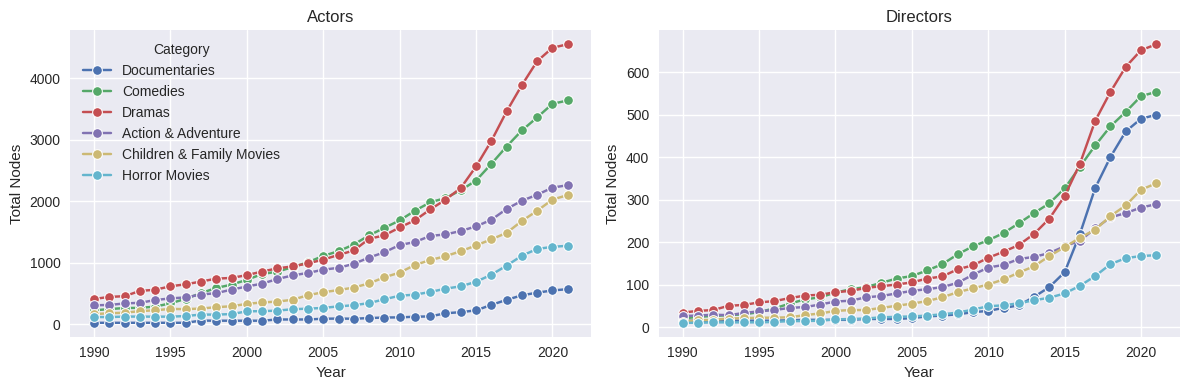

In [ ]:
# Define the metrics to plot
metrics = ['nodes Actors', 'nodes Directors']

# Define the titles for each plot
titles = ['Actors', 'Directors']

# Plot Average Degree for Actors and Directors
plot_metric(df_nodes, metrics, titles, 'Total Nodes')



## Degree Overtime

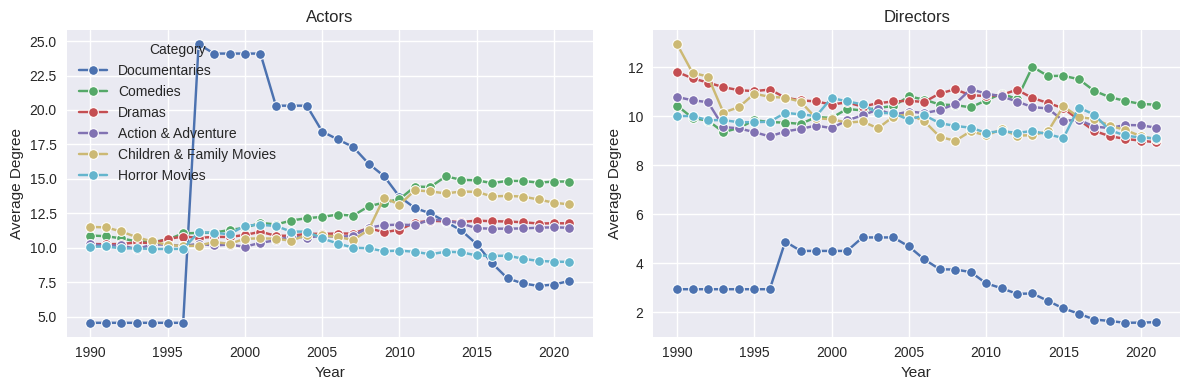

In [ ]:
# Define the metrics to plot
metrics = ['Avg Degree Actors', 'Avg Degree Directors']

# Define the titles for each plot
titles = ['Actors', 'Directors']

# Plot Average Degree for Actors and Directors
plot_metric(df_results, metrics, titles, 'Average Degree')


## Average Distance Overtime

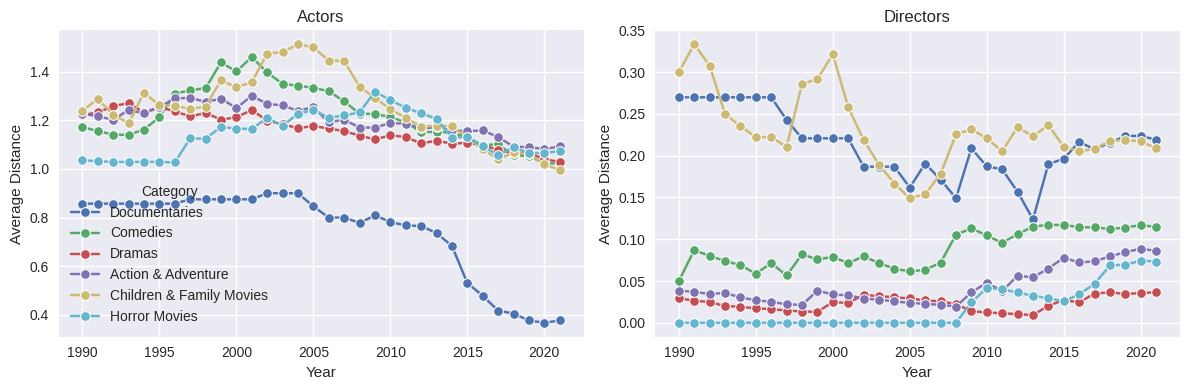

In [ ]:
# Define the metrics to plot
metrics = ['Avg Distance Actors', 'Avg Distance Directors']
# Define the titles for each plot
titles = ['Actors', 'Directors']
# Plot Average Degree for Actors and Directors
plot_metric(df_results, metrics, titles, 'Average Distance')


## Average Cluster overtime

A different behavior is observed when comparing the average distance between Directors and actors. Both portray different levels of distance. while the former ranges from zero to 0.35 on average, that of actors scales from 0.4 to 1.5. Furthermore, a subtly positive trend is observed for actors whereas actors' distance gets closer as time passes.
**commparision btw categories btw actors and directors

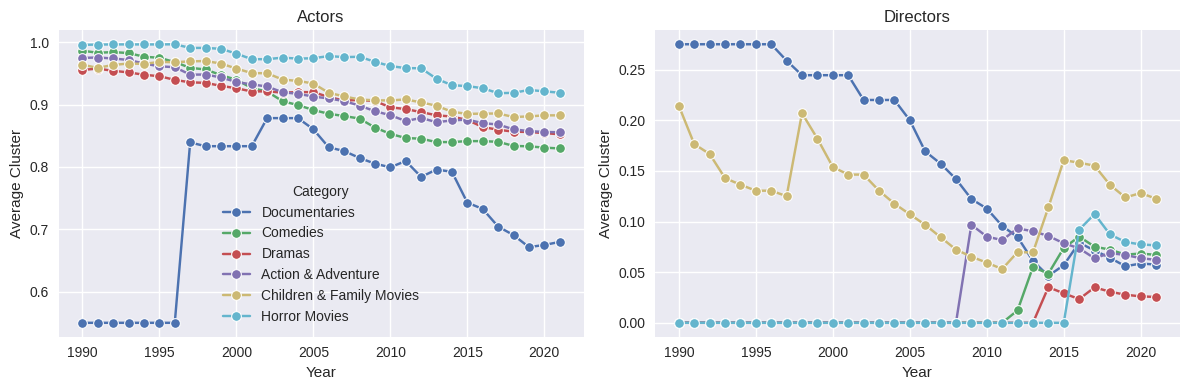

In [ ]:
# Define the metrics to plot
metrics = ['Avg Cluster Actors', 'Avg Cluster Directors']
# Define the titles for each plot
titles = ['Actors', 'Directors']
# Plot Average Degree for Actors and Directors
plot_metric(df_results, metrics, titles, 'Average Cluster')


## Average Preferential attachment overtime

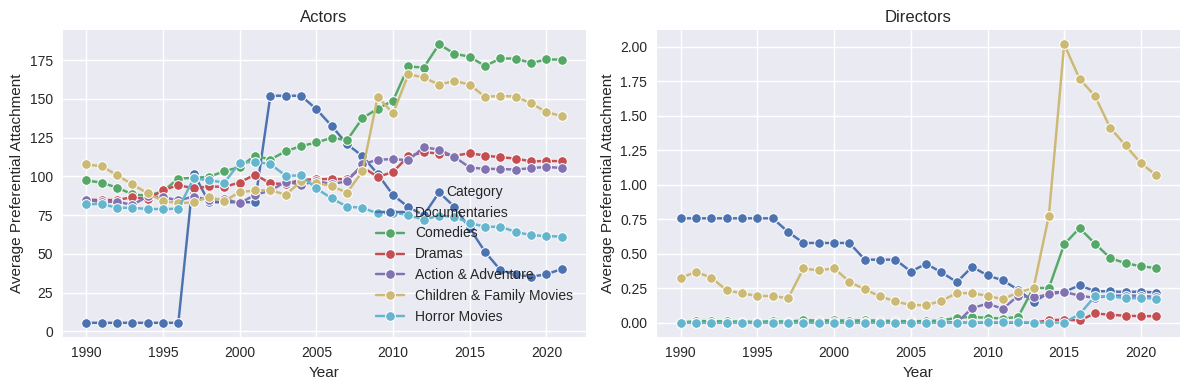

In [ ]:
# Define the metrics to plot
metrics = ['Avg pa Actors', 'Avg pa Directors']
# Define the titles for each plot
titles = ['Actors', 'Directors']
# Plot Average Degree for Actors and Directors
plot_metric(df_nodes, metrics, titles, 'Average Preferential Attachment')


In [ ]:
def visualize_collaborations(node):
    if node in G:
        neighbors = list(G.neighbors(node))

        # Create a subgraph containing the queried node and its neighbors
        subgraph = G.subgraph([node] + neighbors)

        plt.figure(figsize=(10, 6))

        # Draw the subgraph
        pos = nx.spring_layout(subgraph)  # Positions of the nodes
        labels = {n: n for n in subgraph.nodes()}  # Labels for all nodes

        # Set the color for the main node and its neighbors based on their type
        node_colors = ['red' if subgraph.nodes[n]['type'] == 'director' else 'blue' for n in subgraph.nodes()]

        # Draw the subgraph with node labels
        nx.draw(subgraph, pos=pos, with_labels=True, labels=labels, node_color=node_colors, edge_color="gray")

        # Create legend entries
        legend_labels = ["Director", "Actors"]

        # Create legend colors
        legend_colors = ["red", "blue"]

        # Create custom legend elements
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=5)
                           for label, color in zip(legend_labels, legend_colors)]

        # Create legend
        plt.legend(handles=legend_elements, loc="upper right", facecolor="white", framealpha=1)

        # Display the graph
        plt.title(f'Collaboration Graph for {node}')
        plt.show()
    else:
        print(f'Node "{node}" not found in the graph.')

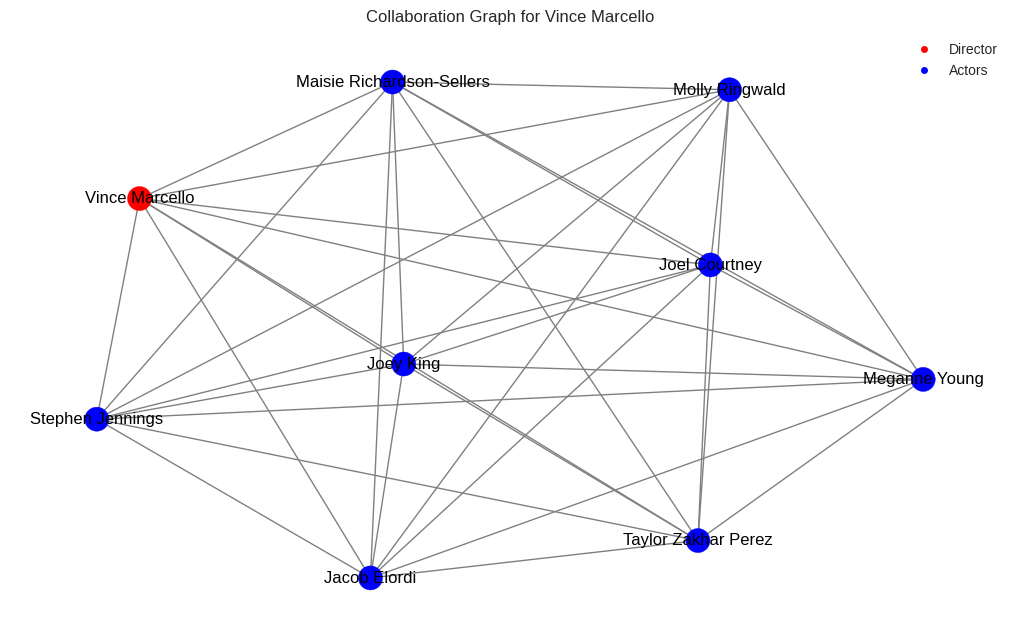

In [ ]:
visualize_collaborations("Vince Marcello")